In [68]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=[]


### Melon headed whale vocalizations
Source:
- https://www.mobysound.org/
- http://localhost:8186/tree/Datasets/mobysound/MellonHeaded_MTSTCS


In [2]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import librosa

In [3]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter
from avgn_paper.signalprocessing import spectrogramming as sg
import wave

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### data locations

In [4]:
DSLOC = Path('/mnt/cube/Datasets/mobysound/MellonHeaded_MTSTCS/')

In [5]:
DSLOC

PosixPath('/mnt/cube/Datasets/mobysound/MellonHeaded_MTSTCS')

### load wavs

In [6]:
wavs = list(DSLOC.glob('*.wav'))

In [8]:
wav_df = pd.DataFrame(columns = ['stem', 'path', 'rate'])
for wav in wavs:
    with wave.open(wav.as_posix(), 'rb') as f:
        rate = f.getframerate()
    wav_df.loc[len(wav_df)] = [wav.stem, wav, rate]

In [9]:
wav_df

,stem,path,rate
0,MISTCS070124-114000,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000
1,MISTCS070124-112000,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000
2,MISTCS070124-113934,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000
3,MISTCS070124-113000,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000
4,MISTCS070124-111000,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000


In [10]:
wav_df[:3]

,stem,path,rate
0,MISTCS070124-114000,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000
1,MISTCS070124-112000,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000
2,MISTCS070124-113934,/mnt/cube/Datasets/mobysound/MellonHeaded_MTST...,96000


### Load labels

In [11]:
good_clicks = list(DSLOC.glob('*.Good.txt'))

In [83]:
clicks_df = []
for click_label_loc in good_clicks:
    good_clicks_df = pd.read_csv(click_label_loc, delimiter='\t')
    good_clicks_df['stem'] = click_label_loc.stem
    good_clicks_df['click_value'] = 'Good'
    clicks_df.append(good_clicks_df)
clicks_df = pd.concat(clicks_df)
clicks_df.columns = [re.sub(' +', ' ', i) for i in clicks_df.columns]

In [13]:
clicks_df[:3]

,% start time,end time,low freq,high freq,peak freq,centr. freq,Unnamed: 6,stem
0,120.35314,120.35451,11936.23522,47548.39651,88.32861,28750.62782,NaN,MISTCS070124-114000.Good
1,120.43770,120.43898,13613.61962,47290.33737,89.91411,27392.97215,NaN,MISTCS070124-114000.Good
2,121.30293,121.30407,10258.85081,47419.36694,84.14929,22236.85906,NaN,MISTCS070124-114000.Good


In [14]:
clicks_df.columns

Index(['% start time', ' end time', ' low freq', ' high freq', ' peak freq',
       ' centr. freq', 'Unnamed: 6', 'stem'],
      dtype='object')

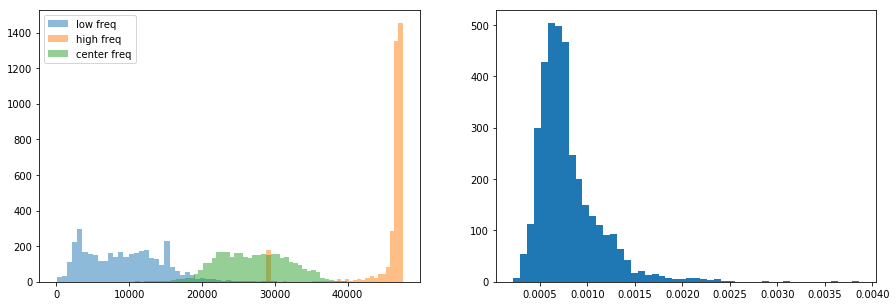

In [82]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
axs[0].hist(clicks_df[' low freq'].values, bins=50, alpha = 0.5, label = 'low freq');
axs[0].hist(clicks_df[' high freq'].values, bins=50, alpha = 0.5, label = 'high freq');
axs[0].hist(clicks_df[' centr. freq'].values, bins=50, alpha = 0.5, label = 'center freq');

axs[1].hist(clicks_df[' end time'].values- clicks_df['% start time'].values, bins=50);
axs[0].legend()

### get example click

In [16]:
click_row = clicks_df.iloc[1]

In [17]:
click_row

% start time                     120.438
 end time                        120.439
 low freq                        13613.6
 high freq                       47290.3
 peak freq                       89.9141
 centr. freq                       27393
Unnamed: 6                           NaN
stem            MISTCS070124-114000.Good
Name: 1, dtype: object

In [18]:
wav_loc = wav_df[wav_df.stem == click_row.stem.split('.')[0]].iloc[0].path
wav_loc

PosixPath('/mnt/cube/Datasets/mobysound/MellonHeaded_MTSTCS/MISTCS070124-114000.wav')

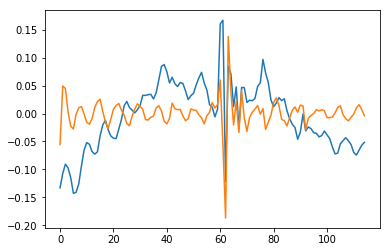

In [69]:
wav_row = wav_df[wav_df.stem == click_row.stem.split('.')[0]].iloc[0]
wav_loc = wav_row.path

rate = wav_row.rate
data, rate = librosa.core.load(
    path=wav_loc,
    sr=None,
    offset=click_row["% start time"],
    duration=click_row[" end time"] - click_row["% start time"],
    mono=False
)
data = np.transpose(data)
click = butter_bandpass_filter(data[:,0], lowcut = 100, highcut=int(rate/2)-2, fs=rate, order=4)
plt.plot(click)
click = butter_bandpass_filter(click, lowcut = 10000, highcut=int(rate/2)-2, fs=rate, order=4)
plt.plot(click)

In [84]:
win_length_ms = .25
hop_length_ms = .02
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=4800,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-50,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=128,
    mel_lower_edge_hertz=1000,
    mel_upper_edge_hertz=rate/2,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)

24.0
1.9200000000000002


In [85]:
spectrogram = sg.spectrogram(click, hparams)

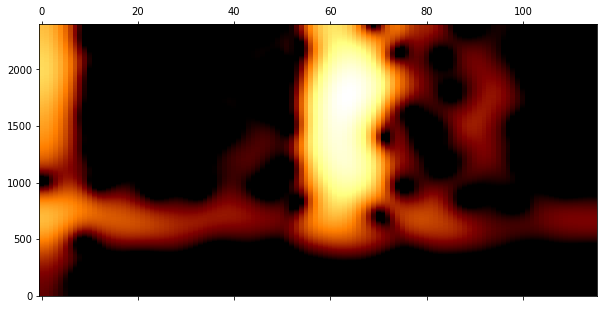

In [86]:
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [87]:
nrow = 3
ncol = 10
zoom_x = 3
zoom_y = 2

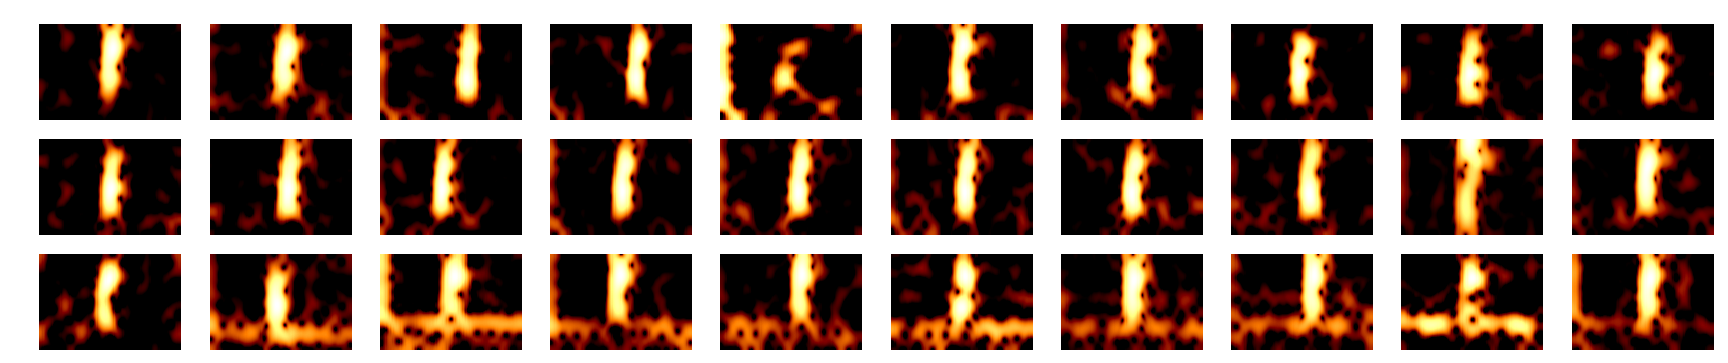

In [88]:
fig, axs = plt.subplots(nrows = nrow, ncols=ncol, figsize=(ncol*zoom_x, nrow*zoom_y))
for axi in tqdm(range(nrow*ncol)):    

    click_row = clicks_df.iloc[axi]
    wav_row = wav_df[wav_df.stem == click_row.stem.split('.')[0]].iloc[0]
    wav_loc = wav_row.path
    
    rate = wav_row.rate
    data, rate = librosa.core.load(
        path=wav_loc,
        sr=None,
        offset=click_row["% start time"],
        duration=click_row[" end time"] - click_row["% start time"],
        mono=False
    )
    data = np.transpose(data)
    
    #audio = int16_to_float32(data)
    audio = butter_bandpass_filter(data[:,0], lowcut = 500, highcut=int(rate/2)-2, fs=rate, order=4)
    spectrogram = sg.spectrogram(audio, hparams)
    #mel_spec = np.dot(spectrogram.T, mel_matrix).T
    ax = axs.flatten()[axi] 
    ax.matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
    ax.axis('off')
plt.show()